In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix,precision_score,recall_score,f1_score
import joblib
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder,TargetEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.feature_selection import mutual_info_classif
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.inspection import permutation_importance

In [4]:
features = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", 
    "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised", 
    "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells", 
    "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count", 
    "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", 
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", 
    "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", 
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate", 
    "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate","Label"
]
training_data = pd.read_csv('/Users/younishubsey/desktop/kddcup.data_10_percent.csv',header = None)
test_data = pd.read_csv('/Users/younishubsey/desktop/corrected.csv',header = None)
test_data.columns = features
training_data.columns = features

In [5]:
test_data = test_data[test_data["Label"].isin(training_data["Label"].unique())]
print(test_data.shape)

(292300, 42)


In [6]:
attack_categories={
'normal.' : 'Normal',

'back.' : 'DoS', 'land.' : 'DoS', 'neptune.' : 'DoS', 'pod.' : 'DoS', 'smurf.' : 'DoS','teardrop.' : 'DoS',

'buffer_overflow.':'U2R', 'loadmodule.':'U2R', 'perl.':'U2R', 'rootkit.': 'U2R',

'ftp_write.' : 'R2L' , 'guess_passwd.':'R2L', 'imap.':'R2L', 'multihop.':'R2L', 'phf.':'R2L', 'spy.':'R2L', 'warezclient.':'R2L', 'warezmaster.':'R2L',

'ipsweep.':'Probing', 'nmap.':'Probing', 'portsweep.':'Probing', 'satan.': 'Probing'
}

training_data['attack_sections']=training_data['Label'].map(attack_categories)
test_data['attack_sections']=test_data['Label'].map(attack_categories)

In [7]:
training_data['attack_sections'] = training_data['Label'].map(attack_categories)
test_data['attack_sections'] = test_data['Label'].map(attack_categories)
print(training_data['attack_sections'].value_counts())

attack_sections
DoS        391458
Normal      97278
Probing      4107
R2L          1126
U2R            52
Name: count, dtype: int64


In [9]:
print(training_data['attack_sections'].value_counts(normalize=True))

attack_sections
DoS        0.792391
Normal     0.196911
Probing    0.008313
R2L        0.002279
U2R        0.000105
Name: proportion, dtype: float64


In [10]:
training_data = training_data[training_data['attack_sections'] != 'U2R']
test_data = test_data[test_data['attack_sections'] != 'U2R']

In [11]:
from sklearn.preprocessing import LabelEncoder
our_categorical_columns = ["Label","attack_sections"]
label_encoder = LabelEncoder()
for col in our_categorical_columns:
    training_data[col]=label_encoder.fit_transform(training_data[col])
    test_data[col] = label_encoder.transform(test_data[col])

In [12]:
from sklearn.preprocessing import OneHotEncoder
only_categorical_features = ["protocol_type", "service", "flag"]
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
train_ohe = encoder.fit_transform(training_data[only_categorical_features])
test_ohe = encoder.transform(test_data[only_categorical_features])
train_encoded_df = pd.DataFrame(train_ohe, columns=encoder.get_feature_names_out(only_categorical_features))
test_encoded_df = pd.DataFrame(test_ohe, columns=encoder.get_feature_names_out(only_categorical_features))
training_data = training_data.drop(columns=only_categorical_features).reset_index(drop=True)
test_data = test_data.drop(columns=only_categorical_features).reset_index(drop=True)
training_data = pd.concat([training_data, train_encoded_df], axis=1)
test_data = pd.concat([test_data, test_encoded_df], axis=1)

In [18]:
x_train =training_data.drop(columns=['Label','attack_sections'])
y_train = training_data['attack_sections']
x_test = test_data.drop(columns = ["Label","attack_sections"])
y_test = test_data["attack_sections"]

In [21]:
feature_drop = [
    
    'hot', 'num_failed_logins', 'num_compromised', 'root_shell', 'su_attempted',
    'num_root', 'num_file_creations', 'num_shells', 'num_access_files',
    'num_outbound_cmds', 'is_host_login', 'is_guest_login',

  
    'srv_count', 'srv_serror_rate', 'srv_rerror_rate',
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate'
]
x_train_select = x_train.drop(columns=feature_drop)
x_test_select = x_test.drop(columns=feature_drop)

In [23]:
smote_tomek = SMOTETomek(sampling_strategy = "not majority",random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(x_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [25]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_resampled)  
X_test_scaled = scaler.transform(x_test) 

In [28]:
from sklearn.neural_network import MLPClassifier
Our_mlp = MLPClassifier(
    hidden_layer_sizes=(128,64,32),
    activation="relu",
    solver="adam",
    learning_rate="adaptive",
    learning_rate_init = 0.001,
    max_iter=1000,
    batch_size=128,
    alpha=0.1,
    n_iter_no_change=40,
    early_stopping = True,
    random_state=42
)

Our_mlp.fit(X_resampled, y_resampled)

MLPClassifier(alpha=0.1, batch_size=128, early_stopping=True,
              hidden_layer_sizes=(128, 64, 32), learning_rate='adaptive',
              max_iter=1000, n_iter_no_change=40, random_state=42)


 Classification Report (Top Features):

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    223298
           1       0.93      0.97      0.95     60593
           2       0.76      0.98      0.86      2377
           3       0.39      0.21      0.28      5993

    accuracy                           0.97    292261
   macro avg       0.77      0.79      0.77    292261
weighted avg       0.97      0.97      0.97    292261



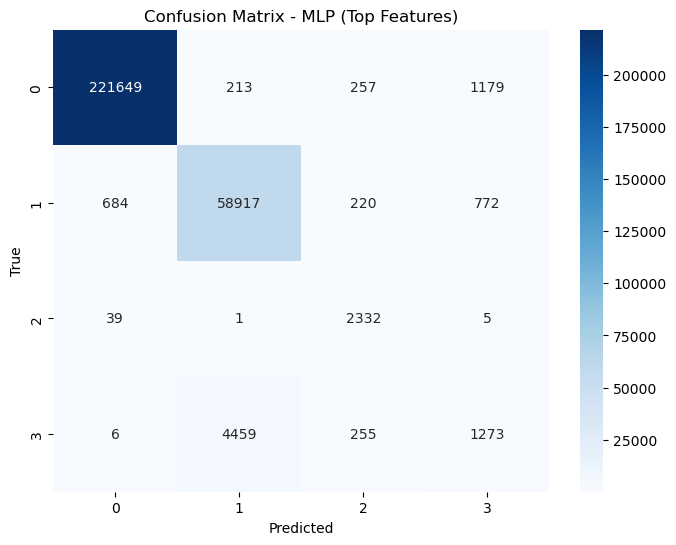

In [29]:
y_pred = Our_mlp.predict(x_test)

print("\n Classification Report (Top Features):\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - MLP (Top Features)")
plt.show()

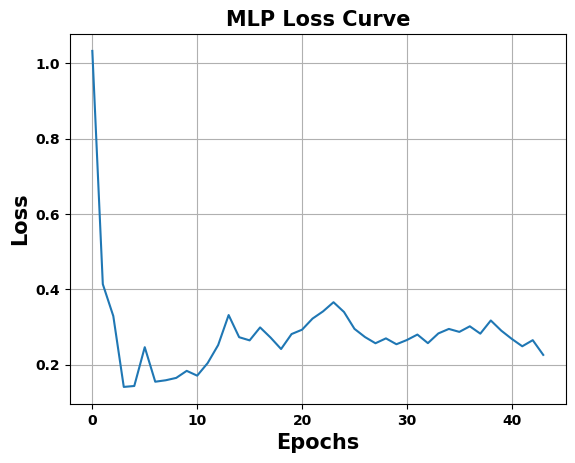

In [30]:
import matplotlib.pyplot as plt
plt.plot(Our_mlp.loss_curve_)
plt.title("MLP Loss Curve",fontweight = 'bold',fontsize = 15)
plt.xlabel("Epochs",fontweight ='bold',fontsize = 15)
plt.ylabel("Loss",fontweight = 'bold',fontsize=15)
plt.xticks(fontsize = 10,fontweight = 'bold')
plt.yticks(fontsize = 10,fontweight ='bold')
plt.grid()
plt.show()


In [31]:
result = permutation_importance(Our_mlp, X_test_scaled, y_test, scoring='f1_macro', n_repeats=10, random_state=42)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-

/var/folders/2d/7dqps2_n0zx5l2_fx7bz690h0000gn/T/ipykernel_16076/828652793.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(20), x='Importance', y='Feature', palette='Blues_d')


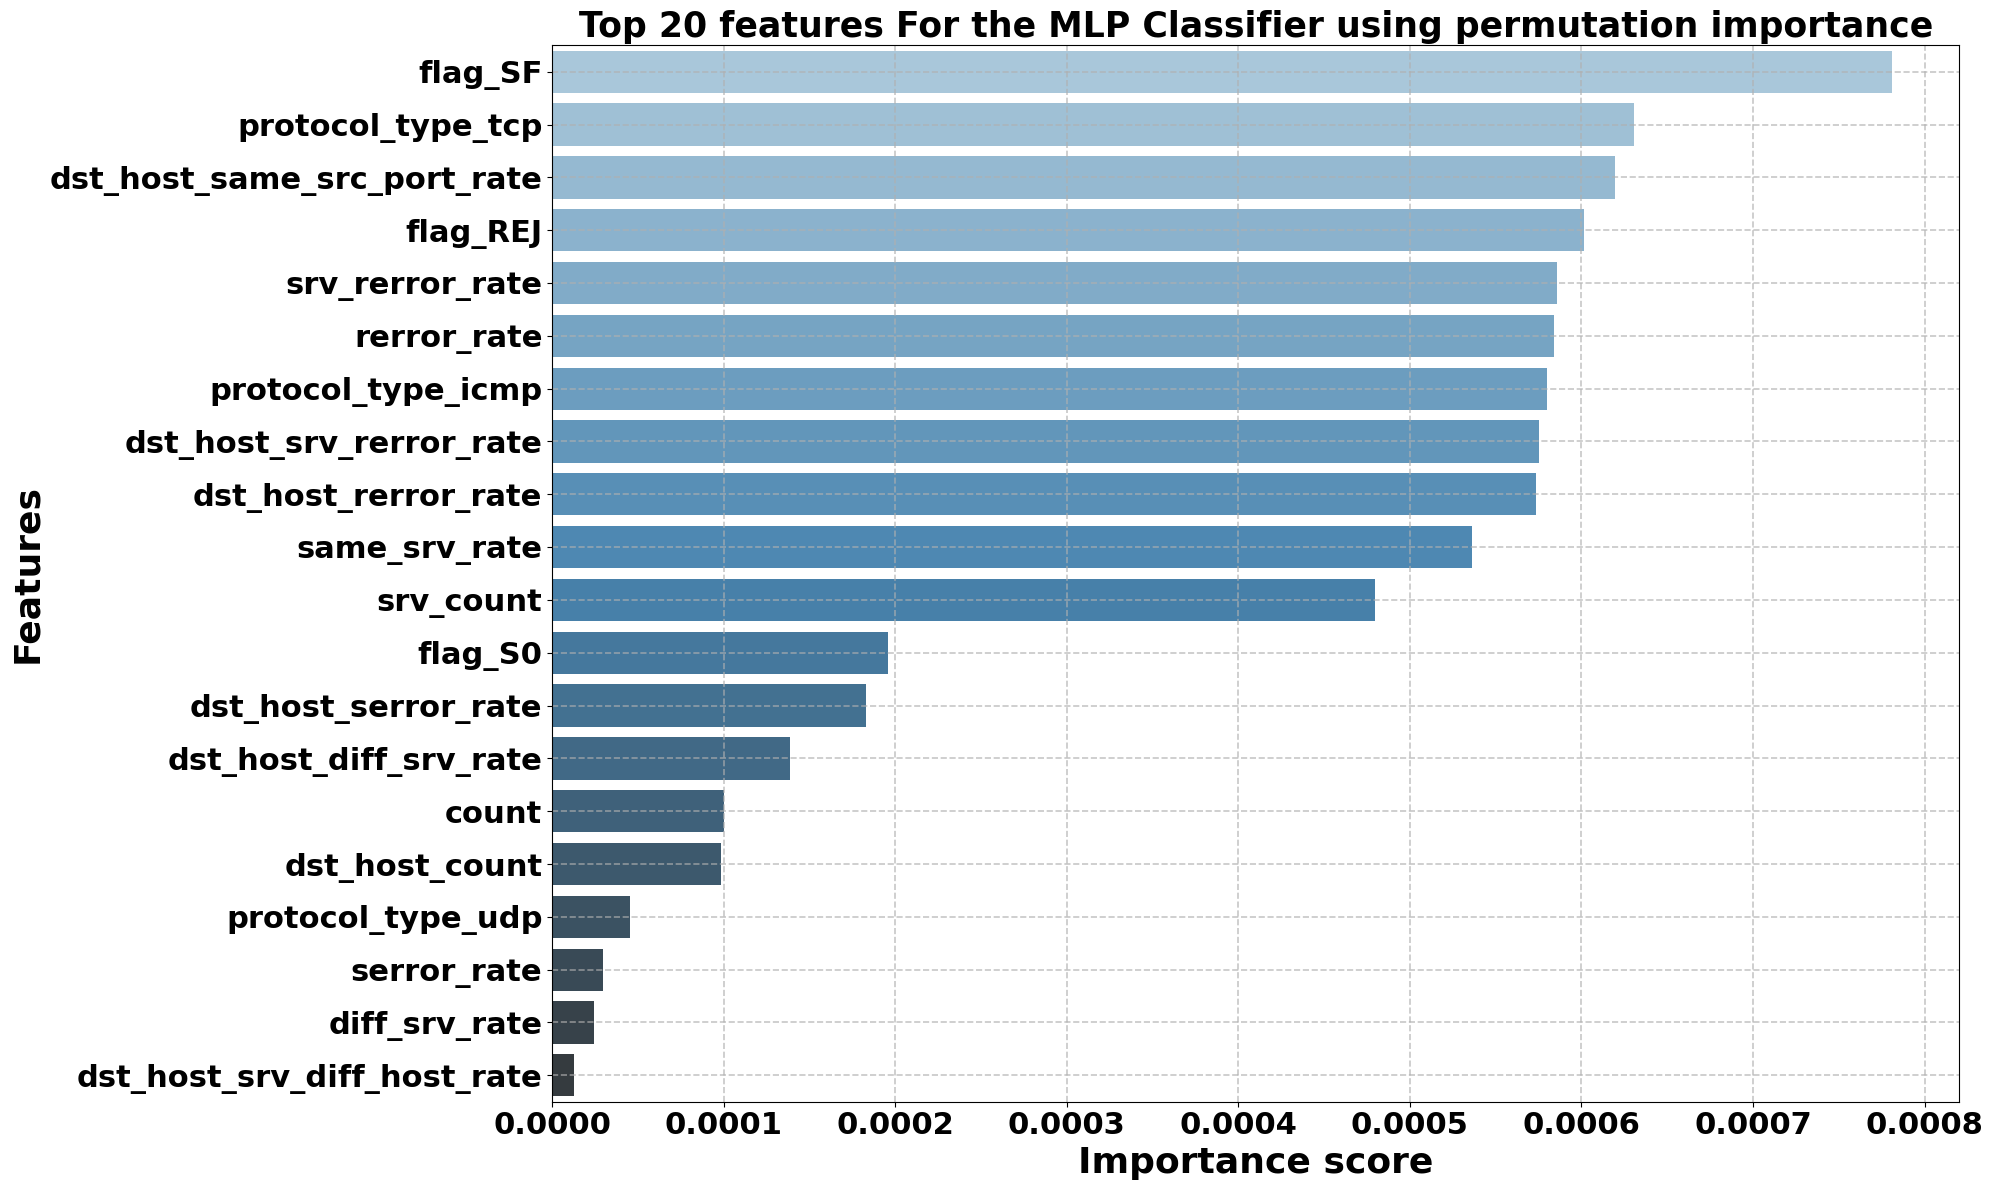

In [32]:

feature_names = x_train.columns 
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(20, 12))
sns.barplot(data=importance_df.head(20), x='Importance', y='Feature', palette='Blues_d')
plt.title("Top 20 features For the MLP Classifier using permutation importance",fontsize=25,fontweight='bold')
plt.xlabel('Importance score',fontsize=26,fontweight='bold')
plt.ylabel('Features',fontsize=26,fontweight='bold')
plt.xticks(fontsize=22,fontweight='bold')
plt.yticks(fontsize=22,fontweight='bold')
plt.tight_layout()
plt.grid(True,linestyle='--',linewidth=1.2,alpha=0.7)
plt.show()

In [33]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=x_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=x_test.columns)
top_23_features = importance_df.head(23)['Feature'].tolist()
X_train_topp = X_train_scaled_df[top_23_features]
X_test_topp = X_test_scaled_df[top_23_features]



 Classification Report (Top Features):

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    223298
           1       0.96      0.96      0.96     60593
           2       0.85      0.86      0.86      2377
           3       0.69      0.84      0.76      5993

    accuracy                           0.98    292261
   macro avg       0.88      0.92      0.89    292261
weighted avg       0.98      0.98      0.98    292261



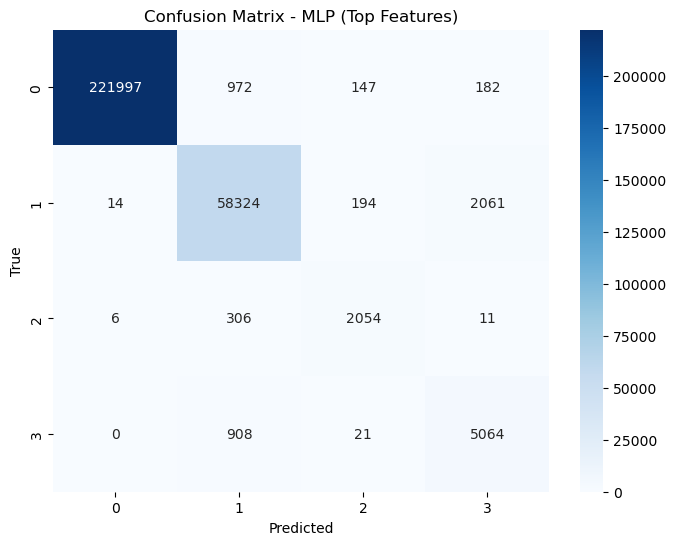

In [34]:
mlp_finall = MLPClassifier(
    hidden_layer_sizes=(128,64,32),
    activation="relu",
    solver="adam",
    learning_rate="adaptive",
    learning_rate_init = 0.01,
    max_iter=1000,
    batch_size=128,
    alpha=0.1,
    n_iter_no_change=40,
    early_stopping = True,
    random_state=42
)
mlp_finall.fit(X_train_topp, y_resampled)
y_pred = mlp_finall.predict(X_test_topp)
print("\n Classification Report (Top Features):\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - MLP (Top Features)")
plt.show()

In [33]:
report_df.to_csv('classification_report.csv')


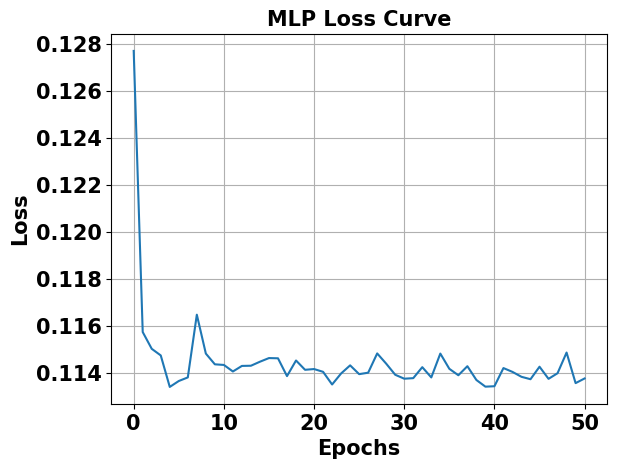

In [50]:
import matplotlib.pyplot as plt
plt.plot(mlp_finall.loss_curve_)
plt.title("MLP Loss Curve",fontsize=15,fontweight='bold')
plt.xlabel("Epochs",fontsize=15,fontweight='bold')
plt.ylabel("Loss",fontsize=15,fontweight='bold')
plt.xticks(fontsize=15,fontweight='bold')
plt.yticks(fontsize=15,fontweight='bold')
plt.grid()
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
stratified = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
MLP_parameters = {
    "hidden_layer_sizes":[(64,32,16),(50,),(200,),(128,64,32),(256,128,64)],
    "max_iter":[1000,200,500],
    "batch_size":[32,64,128],
    "alpha":[1,0.01,0.1]
}
mlp_cv = MLPClassifier(random_state=42,n_jobs=-1)

In [ ]:
mlp_grid= GridSearchCV(
    mlp_cv,
    param_grid = MLP_parameters,
    CV= stratified,
    scoring="recall_macro",
    verbose = 2,
    n_jobs =-1
)
mlp_grid.fit(X_resampled,y_resampled)
print("Best MLP hyperparams: ",mlp_grid.best_params_)